In [251]:
from __future__ import print_function
from __future__ import absolute_import

import numpy as np 
import pandas as pd

import keras
from keras import backend as K
from keras import Model 
from keras import regularizers
from keras.layers import Input, Dense, LSTM
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy, mse
from keras.callbacks import TensorBoard, EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [248]:
iowa_matches = pd.read_csv('/Users/kailinlu/Desktop/QMSSWork/RecordLinking/recordlinker/recordlinker/data/iowa_matches.csv')
iowa_nonmatches = pd.read_csv('/Users/kailinlu/Desktop/QMSSWork/RecordLinking/recordlinker/recordlinker/data/iowa_nonmatches.csv')

In [249]:
iowa_matches.head()

,uid1915,fname1915,lname1915,fullname1915,yob1915,hhid,fname1940,lname1940,fullname1940,yob1940,uid-hhid
0,uid0910071227,donald d,cutler,donald d cutler,1911,19067,donald dean,cutler,donald dean cutler,1911,uid0910071227-19067
1,uid0063131339,homer,taylor,homer taylor,1912,71505,homer ellis,taylor,homer ellis taylor,1912,uid0063131339-71505
2,uid0044088276,earl,stearnes,earl stearnes,1899,109708,earl,stearns,earl stearns,1900,uid0044088276-109708
3,uid0067053130,theodore,hornaday,theodore hornaday,1904,108304,theodore i,harnaday,theodore i harnaday,1904,uid0067053130-108304
4,uid0066046148,jack r,turner,jack r turner,1907,105092,jack r,turner,jack r turner,1907,uid0066046148-105092


In [207]:
def binarize():
    pass

class VariationalAutoencoder():
    '''Variational autoencoder using dense layers'''
    def __init__(self,
                 latent_units,
                 encode_units, 
                 decode_units):
        self.latent_units = latent_units
        self.encode_units = encode_units
        self.decode_units = decode_units

    def _sample_z(self, mu, log_sigma):
        '''Sample epsilon from N(0,I) for reparameterization trick'''
        batch_size = mu.shape[0]
        epsilon = keras.random_normal(shape=(batch_size, self.latent_units))
        return mu + keras.exp(log_sigma / 2.) * epsilon

    def _encode(self, input_x, encode_units):
        encode_layers = []
        for units in encode_units:
            encode_layers.append(Dense(units))
        mu = Dense(self.latent_units)(encode_layers[-1])
        log_sigma = Dense(self.latent_units)(encode_layers[-1])
        return mu, log_sigma

    def _decode(self, input_x, sample_z, decode_units):
        decode_layers = [] 
        for units in decode_units: 
            decode_layers.append(Dense(units))
        return Dense(input_x.shape[1])
        # Save median_mu as part of the computational graph
        
    def _build_model(self, input_x, true_x, lr):
        inp = Input(shape=(input_x.shape[1],))
        mu, log_sigma = self._encode(inp, self.encode_units)
        z = self._sample_z(mu, log_sigma)
        out = self._decode(input_x, z, self.decode_units)
        
        # z_binary = binarize(mu)
        # median_mu = K.variable
        
        loss = mse(true_x, out)
        adam = Adam(lr=lr)
        model = Model(inputs=inp, outputs=z_binary)
        model.compile(optimizer=adam, metrics='cross_entropy', loss=loss)
        print(model.summary())
        return model, encoder, decoder

    def train(self, namesA, namesB, save_path, test_size=TEST_SIZE,
              epochs=EPOCHS, lr=LEARNING_RATE, batch_size=BATCH_SIZE):
        # Inputs - check tensor shapes

        model = self._build_model()

        callbacks = [EarlyStopping(monitor='val_loss', min_delta=.0001, patience=3),
                    TensorBoard()]

        model.fit(x=namesA, y=namesB,
                  batch_size=batch_size, epochs=epochs,
                  callbacks=callbacks, validation_split=test_size)

        # Save model, encoder, decoder 
        
        # Return fitted model, encoder, decoder
        pass

In [201]:
vae = VariationalAutoencoder(latent_units=4, encode_units=[128,64], decode_units=[64,128]) 

In [258]:
K.clear_session() 

from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_size = x_train.shape[1]
latent_units = 8 
encode_units = [16,16]
decode_units = [8]

encode_layers = [] 
inp = Input(shape=(input_size,))
encode_layers.append(inp) 
for i, units in enumerate(encode_units): 
    encode_layers.append(Dense(units, 
                               activation='relu',
                               activity_regularizer=regularizers.l1(1e-6), 
                               name='encode_{}'.format(i))(encode_layers[-1])) 

latent = Dense(latent_units, activation='relu', name='latent')(encode_layers[-1])

decode_layers = [latent]
for i, units in enumerate(decode_units):
    decode_layers.append(Dense(units, activation='relu', name='decode_{}'.format(i))(decode_layers[-1])) 

out = Dense(input_size, activation='sigmoid', name='reconstruction')(decode_layers[-1])
model = Model(inp, out)
model.compile(optimizer='adadelta', loss='binary_crossentropy')
print(model.summary())

model.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
encode_0 (Dense)             (None, 16)                12560     
_________________________________________________________________
encode_1 (Dense)             (None, 16)                272       
_________________________________________________________________
latent (Dense)               (None, 8)                 136       
_________________________________________________________________
decode_0 (Dense)             (None, 8)                 72        
_________________________________________________________________
reconstruction (Dense)       (None, 784)               7056      
Total params: 20,096
Trainable params: 20,096
Non-trainable params: 0
_________________________________________________________________
None
T

In [256]:
encoder = Model(inp, latent)

encoded_input = Input(shape=(latent_units,))
decoder_layer = model.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

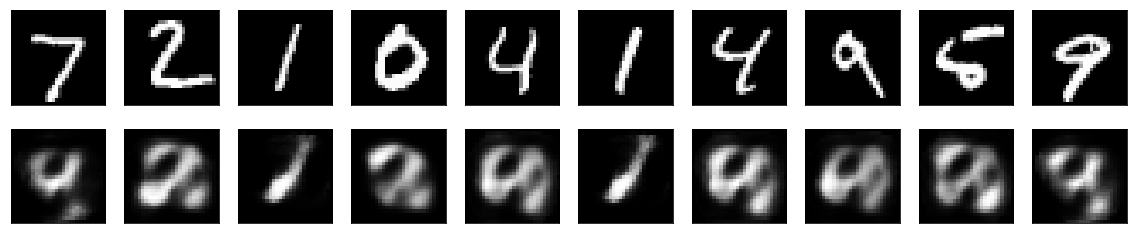

In [257]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()